In [1]:
# worldcam correction testing
# pulled from analyze_ephys.py
# TO DO: organize into a usable function at some point

In [2]:
cd t:\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\hf1_wn

t:\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\hf1_wn


In [3]:
name_base = '012821_EE8P6LT_control_Rig2_hf1_wn'

eye_file = name_base + '_Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

#free_move = True; has_imu = True; has_mouse = False;
free_move = False; has_imu = False; has_mouse = False;
#stim_type = 'grat'

In [4]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.ndimage import shift as imshift
from scipy import signal
from sklearn.cluster import KMeans

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])
sz = world_vid_raw.shape
downsamp = 1
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data
world_vid_raw = None

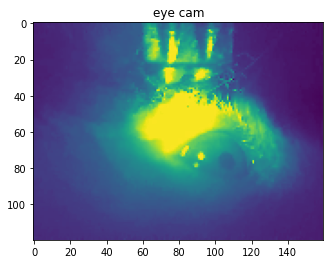

In [6]:
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
#omega = np.squeeze(np.array(eye_data['REYE_omega']))

In [7]:
print('opening ephys data')
ephys_data = pd.read_json(ephys_file)
ephys_data['spikeTraw'] = ephys_data['spikeT']

# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values

# get number of good units
n_units = len(goodcells)

opening ephys data


In [8]:
if free_move & has_imu:
    imu_data = xr.open_dataset(imu_file)
    acc_chans = imu_data.IMU_data
    gx = np.array(acc_chans.sel(channel='gyro_x'))
    gy = np.array(acc_chans.sel(channel='gyro_y'))
    gz = np.array(acc_chans.sel(channel='gyro_z'))

In [9]:
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move & has_imu:
    accTraw = imu_data.timestamps-ephysT0
if (free_move==False) & has_mouse:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 37882)>
 array([ -0.845834,  -0.833591,  -0.817559, ..., 631.170557, 631.186589,
        631.19544 ])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 37877 37878 37879 37880 37881
     timestamps  (frame) float64 4.286e+04 4.286e+04 ... 4.349e+04 4.349e+04,
 <xarray.DataArray 'timestamps' (frame: 37881)>
 array([ -0.8394625,  -0.8249725,  -0.8089215, ..., 631.1496575,
        631.1650945, 631.1811455])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 37876 37877 37878 37879 37880
     timestamps  (frame) float64 4.286e+04 4.286e+04 ... 4.349e+04 4.349e+04)

In [10]:
offset0 = 0.1;
drift_rate = -0.1/1000;
#for i in range(len(ephys_data)):
#    ephys_data['spikeT'][i] = np.array(ephys_data['spikeTraw'].iloc[i]) - (offset0 + np.array(ephys_data['spikeTraw'].iloc[i]) *drift_rate)
if free_move & has_imu:
    accT= accTraw - (offset0 + accTraw*drift_rate)

Text(0, 0.5, 'phi')

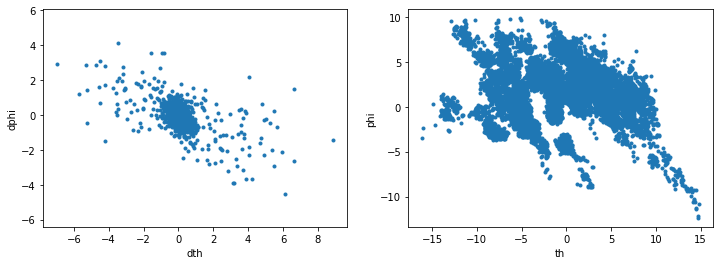

In [11]:
th_interp = interp1d(eyeT,th,bounds_error = False)
phi_interp = interp1d(eyeT, phi, bounds_error = False)
#omega_interp = interp1d(eyeT, omega, bounds_error = False)
dth = np.diff(th_interp(worldT))
dphi = np.diff(phi_interp(worldT))

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(dth[0:60*60*5],dphi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('dth')
plt.ylabel('dphi')

plt.subplot(1,2,2)
plt.plot(th[0:60*60*5],phi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('th')
plt.ylabel('phi')

In [ ]:
# get worldcam correction based on eye-movement vs frameshift regression
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_EUCLIDEAN
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
    warp_all = np.zeros((6,max_frames))
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        try: 
            (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
            warp_all[:,i] = np.reshape(warp_matrix,6)
        except:
            cc[i] = np.nan;
            xshift[i]=np.nan; yshift[i] = np.nan;
            warp_all[:,i] = np.nan

In [ ]:
if free_move:
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    plt.plot(dth[0:max_frames])
    plt.plot(warp_all[1,0:max_frames]*50)
    plt.xlim(0,600)
    plt.ylim(-10,10)
    
    plt.subplot(2,1,2)
    plt.plot(-dphi[0:max_frames])
    plt.plot(warp_all[1,0:max_frames]*50)
    plt.xlim(0,600)
    plt.ylim(-10,10)


In [ ]:
if free_move:
    plt.figure(figsize = (8,6))
    plt.subplot(2,2,1)
    plt.plot(dth[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('xshift')
    plt.subplot(2,2,2)
    plt.plot(dth[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('yshift')
    plt.subplot(2,2,3)
    plt.plot(dphi[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('xshift')
    plt.subplot(2,2,4)
    plt.plot(dphi[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('yshift')
    plt.tight_layout()

    plt.figure(figsize = (12,12))
    plt.subplot(3,1,1)
    plt.plot(worldT[0:max_frames],cc); plt.ylabel('cc')

    plt.subplot(3,1,2)
    plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
    plt.plot(accT,(gz-np.mean(gz))*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    #plt.plot(eyeT[0:-1],-dEye,label = 'eye dtheta')
    plt.xlim(0,2); plt.ylim(-5,5)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(worldT[0:max_frames],0.5*xshift, label = 'image x shift');
    #plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    plt.plot(worldT[0:-1],-dth,'r',label = 'eye dtheta', alpha = 1)
    plt.xlim(0,5); plt.ylim(-8,8)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()
    plt.tight_layout()




In [13]:
if free_move:
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    rotmodel = LinearRegression()
    
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    
    rotshiftdata = warp_all[1,0:max_frames];
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)
    
    # fit xshift
    
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
    xmap = xmodel.coef_;
    xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
    print(xmap, xrscore)

    xfit = xmap[0]* dth + xmap[1]*dphi;
    plt.figure(figsize = (12,4))
    plt.plot(xshiftdata, label = 'xshift')
    plt.plot(xfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    plt.figure(figsize = (6,6))
    plt.plot(xshiftdata,xfit[0:len(xshiftdata)],'.'); plt.xlim(-10,10); plt.ylim(-10,10)

    # fit yshift
    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])

    ymap = ymodel.coef_;
    yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])

    yfit = ymap[0] * dth + ymap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(yshiftdata, label = 'yshift')
    plt.plot(yfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    print(ymap,yrscore)
    
    # fit rotation shift
    rotmodel.fit(eyeData[usedata,:],rotshiftdata[usedata])

    rotmap = rotmodel.coef_;
    rotrscore = rotmodel.score(eyeData[usedata,:],rotshiftdata[usedata])

    rotfit = rotmap[0] * dth + rotmap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(rotshiftdata, label = 'rotshift')
    plt.plot(rotfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-0.2,0.2)


    print(rotmap,rotrscore)

else:
    xmap = [-1.47,  0.32]
    ymap =[0.71,  0.55]


In [14]:
print(xmap,ymap)

[-1.47, 0.32] [0.71, 0.55]


In [ ]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

In [ ]:
if free_move:
    # eye correction movie
    print('getting eye correction movie')
    tr = [30,35]
    fig = plt.figure(figsize = (8,16))
    gs = fig.add_gridspec(10,1)
    axEye = fig.add_subplot(gs[0,0])
    axWorld = fig.add_subplot(gs[0:3,:])
    axWorldFix = fig.add_subplot(gs[3:6,:])

    axTheta = fig.add_subplot(gs[6,:])
    axPhi = fig.add_subplot(gs[7,:])
    axOmega = fig.add_subplot(gs[8,:])
    axGyro = fig.add_subplot(gs[9,:])

    th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
    phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

    axTheta.plot(eyeT,th)
    axTheta.set_xlim(tr[0],tr[1]); 
    axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

    axPhi.plot(eyeT,phi)
    axPhi.set_xlim(tr[0],tr[1]); 
    axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

    #axOmega.plot(eyeT,omega)
    axOmega.set_xlim(tr[0],tr[1]); 
    axOmega.set_ylabel('omega - deg'); axOmega.set_ylim(-20,20)

    if free_move & has_imu:
        axGyro.plot(accT,gz)
        axGyro.set_xlim(tr[0],tr[1]); 
        axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(2,4)

    thInterp =interp1d(eyeT,th)
    phiInterp =interp1d(eyeT,phi)
    pix_per_deg = 1.6

    vidfile = name_base +'_corrected.mp4'
    # now animate
    writer = FFMpegWriter(fps=30)
    with writer.saving(fig, vidfile, 100):
    #    for t in np.arange(tr[0],tr[1],1/30):
        for t in tqdm(worldT[(worldT>tr[0]) & (worldT<tr[1])]):        
            # show eye and world frames
            axEye.cla(); axEye.axis('off'); 
            axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
            #axEye.set_xlim(0,160); axEye.set_ylim(0,120)

            world = worldInterp(t)
            axWorld.cla(); axWorld.axis('off'); 
            axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
            #om = np.radians(omega_interp(t))
            #axWorld.plot([80 - 32*np.cos(om), 80 + 32*np.cos(om)], [80 + 32*np.sin(om), 80 - 32*np.sin(om)])

            worldFix= np.roll(world,(-np.int8(thInterp(t)*ymap[0] + phiInterp(t)*ymap[1]),-np.int8(thInterp(t)*xmap[0] + phiInterp(t)*xmap[1])),axis = (0,1))
            axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')

            #plot line for time, then remove
            ln1 = axTheta.vlines(t,-0.5,30,'b')
            ln2 = axPhi.vlines(t,-0.5,30,'b')
            writer.grab_frame()
            ln1.remove()
            ln2.remove()



'shifting worldcam'

'applying gamma to camera'

100%|██████████████████████████████████████████████████████████████████████████| 37881/37881 [00:23<00:00, 1598.94it/s]


'normalizing world cam'

'setting up worldcam interpolator'

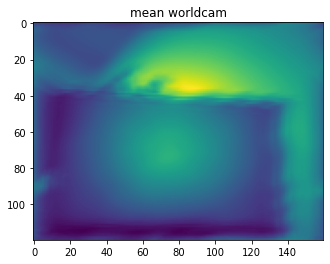

In [15]:
display('shifting worldcam')
xcorrection = xmap.copy()
ycorrection = ymap.copy()

#xcorrection = [0,0]; ycorrection= [0,0]

display('applying gamma to camera')
cam_gamma = 2
world_norm = (world_vid/255)**cam_gamma

thInterp =interp1d(eyeT,th, bounds_error = False)
phiInterp =interp1d(eyeT,phi, bounds_error = False)

for f in tqdm(range(np.shape(world_vid)[0])):
    world_norm[f,:,:] = np.roll(world_norm[f,:,:],(-np.int8(thInterp(worldT[f])*ycorrection[0] + phiInterp(worldT[f])*ycorrection[1]),-np.int8(thInterp(worldT[f])*xcorrection[0] + phiInterp(worldT[f])*xcorrection[1])),axis = (0,1))

display('normalizing world cam')
plt.imshow(np.mean(world_norm,axis=0)); plt.title('mean worldcam')
std_im = np.std(world_norm,axis=0)
std_im[std_im<10/255] = 10/255
img_norm = (world_norm-np.mean(world_norm,axis=0))/std_im
img_norm = img_norm * (std_im>10/255)
world_norm = None;

display('setting up worldcam interpolator')
img_norm[img_norm<-2] = -2
movInterp = interp1d(worldT,img_norm,axis=0, kind = 'nearest')

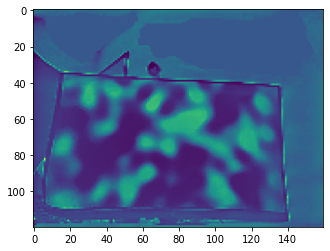

In [16]:
plt.imshow(img_norm[100,:,:])

100%|████████████████████████████████████████████████████████████████████████████| 1545/1545 [00:00<00:00, 4290.04it/s]
<ipython-input-17-dff425033e67>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n_units/4),4,c+1)
100%|██████████████████████████████████████████████████████████████████████████| 13747/13747 [00:03<00:00, 4451.27it/s]


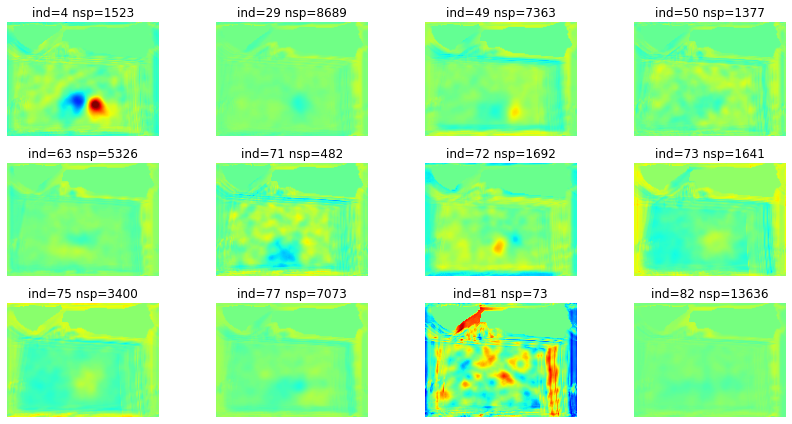

In [17]:
staAll = np.zeros((n_units,np.shape(img_norm)[1],np.shape(img_norm)[2]))
lag = 0.075
fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    sta = 0; nsp = 0
    sp = goodcells.at[ind,'spikeT'].copy()
    if c==1:
        ensemble = np.zeros((len(sp),np.shape(img_norm)[1],np.shape(img_norm)[2]))
    for s in tqdm(sp):
        if (s-lag >5) & ((s-lag) <np.max(worldT)):
            nsp = nsp+1
            im = movInterp(s-lag)
            # if c==1:
            #     ensemble[nsp-1,:,:] = im
            #im= np.roll(im,(-np.int8(thInterp(s-lag)*ycorrection[0] + phiInterp(s-lag)*ycorrection[1]),-np.int8(thInterp(s-lag)*xcorrection[0] + phiInterp(s-lag)*xcorrection[1])),axis = (0,1))
            sta = sta+im
    plt.subplot(np.ceil(n_units/4),4,c+1)
    #plt.title(str(nsp))
    plt.title(f'ind={ind!s} nsp={nsp!s}')
    plt.axis('off')
    if nsp > 0:
        sta = sta/nsp
    else:
        sta = np.nan
    if pd.isna(sta) is True:
        plt.imshow(np.zeros([120,160]))
    else:
        plt.imshow((sta-np.mean(sta) ),vmin=-0.6,vmax=0.6,cmap = 'jet')
        staAll[c,:,:] = sta
plt.tight_layout()

In [ ]:
lagRange = np.arange(-0.05,0.2,0.05)
fig = plt.figure(figsize = (12,2*n_units))
for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for  lagInd, lag in enumerate(lagRange):
        sta = 0; nsp = 0
        for s in sp:
            if (s-lag >5) & ((s-lag) <np.max(worldT)):
                nsp = nsp+1
                sta = sta+movInterp((s-lag))
        plt.subplot(n_units,6,(c*6)+lagInd + 1)
        if nsp > 0:
            sta = sta/nsp
        else:
            sta = np.nan
        if pd.isna(sta) is True:
            plt.imshow(np.zeros([120,160]))
        else:
            plt.imshow((sta-np.mean(sta) ),vmin=-0.3,vmax=0.3,cmap = 'jet')
        # plt.title(str(c) + ' ' + str(np.round(lag*1000)) + 'msec')
        if c == 0:
            plt.title(str(np.round(lag*1000)) + 'msec')
        plt.axis('off')
plt.tight_layout()


In [ ]:
stop here

In [ ]:
# get worldcam correction based on eye-movement vs frameshift regression
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_EUCLIDEAN
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);omegashift = np.zeros(max_frames)
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
        omegashift[i] = np.arctan2(warp_matrix[0,1],warp_matrix[0,0])

In [ ]:
plt.plot(worldT[0:max_frames],np.cumsum(omegashift*180/3.14))
plt.plot(eyeT[0:max_frames], omega[0:max_frames]-8)
plt.xlim([30,40])

In [ ]:
plt.plot(eyeT[0:max_frames],omega[0:max_frames])
plt.xlim([15,20])

In [ ]:
#correct movie
max_frames = 60*60
thInterp =interp1d(eyeT,th, bounds_error = False, fill_value = 0)
phiInterp =interp1d(eyeT,phi, bounds_error = False, fill_value = 0)

world_fix = np.zeros((max_frames, np.size(world_vid,1), np.size(world_vid,2)),'uint8')
for f in tqdm(range(max_frames)):
    t = worldT[f]
    thInt = thInterp(t)
    if np.isnan(thInt):
        thInt =0
    phiInt = phiInterp(t) 
    if np.isnan(phiInt):
        phiInt =0

    world_fix[f,:,:]= imshift(world_vid[f,:,:],(-(thInt*ymap[0] + phiInt*ymap[1]),-(thInt*xmap[0] + phiInt*xmap[1])))



In [ ]:
#compare alignement pre and post correction
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
warp_mode = cv2.MOTION_TRANSLATION
cc_fix = np.zeros(max_frames); xshift_fix = np.zeros(max_frames); yshift_fix = np.zeros(max_frames);
for i in tqdm(range(max_frames-1)):
    try:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc_fix[i], warp_matrix) = cv2.findTransformECC (world_fix[i,:,:],world_fix[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift_fix[i] = warp_matrix[0,2]; yshift_fix[i] = warp_matrix[1,2]
    except:
        xshift_fix[i] = np.nan; yshift_fix[i] = np.nan # very rarely, a frame will raise cv2 error when iterations do not converge for transform

if free_move:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(xshift,label = 'x pre alignment')
    plt.plot(xshift_fix,label = 'x post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    plt.subplot(2,1,2)
    plt.plot(yshift,label = 'y pre alignment')
    plt.plot(yshift_fix, label = 'y post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    diagnostic_pdf.savefig()
    plt.close()



In [ ]:
# get optic flow pre/post correction
max_frame = 60*60
flow = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
flow_fix = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
x,y = np.meshgrid(np.arange(0, np.size(world_vid,2)), np.arange(0,np.size(world_vid,1)))
vidfile = os.path.join(file_dict['save'], (file_dict['name']+'_flowfix.mp4'))

print('plotting video of optical flow')
fig, axs = plt.subplots(1,2,figsize = (16,8))
# now animate
writer = FFMpegWriter(fps=30)
nx = 5
with writer.saving(fig, vidfile, 100):
    for f in tqdm(range(max_frame-1)):

        flow[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_vid[f,:,:],world_vid[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[0].cla()
        axs[0].imshow(world_vid[f,:,:],vmin = 0, vmax = 255)
        u = flow[f,:,:,0]; v = flow[f,:,:,1]
        axs[0].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        flow_fix[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_fix[f,:,:],world_fix[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[1].cla()
        axs[1].imshow(world_fix[f,:,:],vmin = 0, vmax = 255)
        u = flow_fix[f,:,:,0]; v = flow[f,:,:,1]
        axs[1].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        writer.grab_frame()